In [9]:
import json
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
# load all events from store
all_events = list( json.loads(event) for event in open('eventstore.json', 'rt') )
# convert timestamp to datetime object
for event in all_events:
    event.update({'datetime': datetime.fromtimestamp(event['timestamp'] / 1000)})

In [17]:
destination_events = list(filter(lambda e: e['class'] == 'SetDestinationEvent', all_events))

destinations = destination_events

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from pygeocoder import Geocoder

def cluster_destinations(destinations):
    S = np.array(destinations)
    X = np.array([ [ d['latitude'], d['longitude'] ] for d in destinations ])
    db = DBSCAN(eps=0.0005, min_samples=3).fit(X)
    Y = db.labels_
    #print('Overall score {score:.5f}'.format(score=metrics.silhouette_score(X, Y)))
    for label in np.unique(Y):
        if label == -1: continue
        positions = X[Y == label]
        subdestinations = S[Y == label]
        assert(len(positions) == len(subdestinations))
        latitude = np.mean(positions[:,0])
        longitude = np.mean(positions[:,1])        
        address = str(Geocoder.reverse_geocode(latitude, longitude)[0])
        yield {'latitude':latitude, 'longitude':longitude, 'address':address, 'points':subdestinations.tolist()}

In [19]:
from sklearn.neighbors import KernelDensity

priors = []
kernels = []

Xs = []  # store for plotting

clusters = list(cluster_destinations(destination_events))

for cluster in clusters:
    X = np.array( list(map(lambda e: e['datetime'].hour * 60 + e['datetime'].minute, cluster['points'])) )[:, np.newaxis]
    kernel = KernelDensity(kernel='gaussian', bandwidth=15).fit(X)
    kernels.append(kernel)
    Xs.append(X)
    
for cluster in clusters:
    number_of_points = len(cluster['points'])
    priors.append(number_of_points)

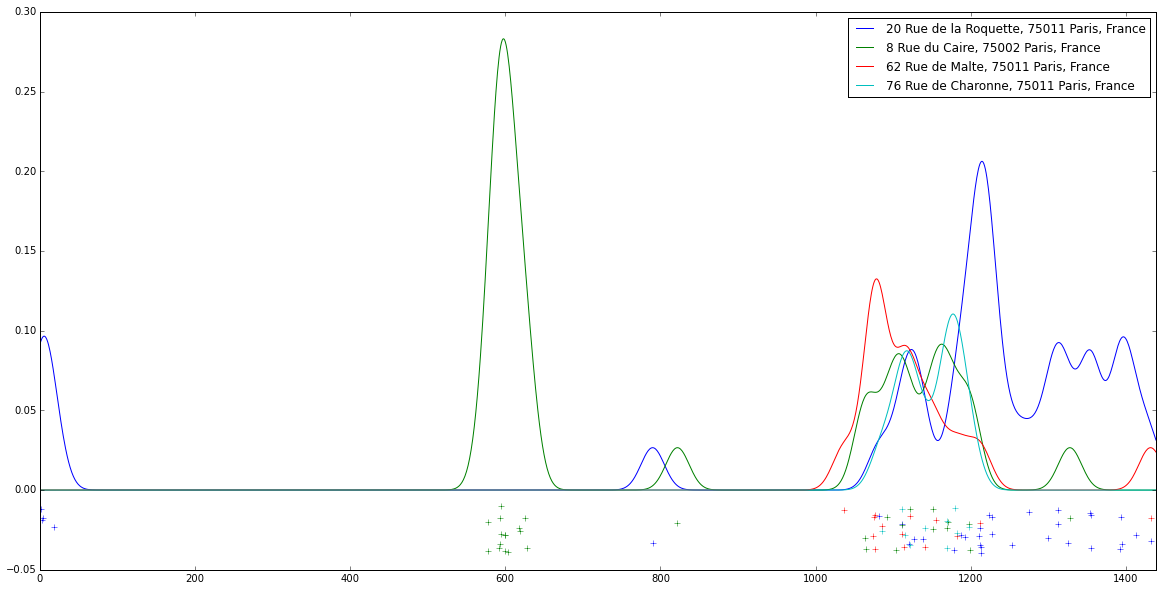

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
xmin = 0
xmax = 24 * 60 - 1

colors = 'bgrcmyk'
for i, cluster in enumerate(clusters):
    kernel = kernels[i]
    X_plot = np.linspace(xmin, xmax, xmax+1)[:, np.newaxis]
    log_density = kernel.score_samples(X_plot)
    density = np.exp(log_density) * priors[i]
    ax.plot(X_plot[:, 0], density, '-', label=cluster['address'], color=colors[i])
    ax.plot(Xs[i], -0.01 - 0.03 * np.random.random(Xs[i].shape[0]), '+' + colors[i])

ax.legend()#loc='upper left')
ax.set_xlim(xmin, xmax)
plt.show()

In [21]:
def suggest(hour, minute):
    time = hour * 60 + minute
    print(time)
    posteriors = list( (i, np.exp(kernels[i].score(time))) for i, cluster in enumerate(clusters) )
    posteriors.sort(key=lambda x: x[1], reverse=True)
    suggested_destinations = list( clusters[i] for i, _ in posteriors )

    for i, suggested_destination in enumerate(suggested_destinations):
        print('{0}: {1}'.format(i, suggested_destination['address']))

now = datetime.now()
suggest(now.hour, now.minute)
print()
        
suggest(9, 45)
print()

suggest(19, 15)
print()

48
0: 20 Rue de la Roquette, 75011 Paris, France
1: 8 Rue du Caire, 75002 Paris, France
2: 62 Rue de Malte, 75011 Paris, France
3: 76 Rue de Charonne, 75011 Paris, France

585
0: 8 Rue du Caire, 75002 Paris, France
1: 20 Rue de la Roquette, 75011 Paris, France
2: 62 Rue de Malte, 75011 Paris, France
3: 76 Rue de Charonne, 75011 Paris, France

1155
0: 76 Rue de Charonne, 75011 Paris, France
1: 62 Rue de Malte, 75011 Paris, France
2: 8 Rue du Caire, 75002 Paris, France
3: 20 Rue de la Roquette, 75011 Paris, France



In [175]:
d = datetime(2015,12,20)
weeknumber = d.isocalendar()[1]

In [14]:
destination_events

[{'class': 'SetDestinationEvent',
  'datetime': datetime.datetime(2015, 6, 17, 22, 41, 32, 124000),
  'latitude': 48.853996711826596,
  'longitude': 2.370336838066578,
  'timestamp': 1434573692124},
 {'class': 'SetDestinationEvent',
  'datetime': datetime.datetime(2015, 6, 17, 22, 47, 53, 352999),
  'latitude': 48.85377985663052,
  'longitude': 2.3706751316785812,
  'timestamp': 1434574073353},
 {'class': 'SetDestinationEvent',
  'datetime': datetime.datetime(2015, 6, 18, 9, 40, 43, 779999),
  'latitude': 48.86747209918419,
  'longitude': 2.3535415157675743,
  'timestamp': 1434613243780},
 {'class': 'SetDestinationEvent',
  'datetime': datetime.datetime(2015, 6, 18, 9, 47, 40, 151999),
  'latitude': 48.86746041026463,
  'longitude': 2.3535267636179924,
  'timestamp': 1434613660152},
 {'class': 'SetDestinationEvent',
  'datetime': datetime.datetime(2015, 6, 18, 9, 50, 10, 823999),
  'latitude': 48.86611131416947,
  'longitude': 2.35089048743248,
  'timestamp': 1434613810824},
 {'class':